## Predicting the user gender based on the tweet information from text

* Natural language is any language that is used by people in everyday like English or Spanish
* NLP is used for any computation and/or manipulation of natural language to get inside about how words mean and how sentences are contructed is natural language processing.
* Natural languages are in change like new words tweets
* Text is everywhere like books, facebook or twitter.
* Text data is growing each passing day. The amount of text data will be approximately 70 zettabytes in approximately next 1-2 years.
* NLP is useful for text mining to sentiment analysis, topic modelling, finding, classfying and extracting information.

There can be multiple things which we can answer using Sentiment analysis such as how well do words in tweets and profiles predict user gender, or what kind of words strongly predict the gender and also how well do stylistic factors(like link color and sidebar color) predict user gender.

### Objective

The goal of this project is to simply view a Twitter profile and judge whether the user was a male, a female, or a brand (non-individual). NLP is used and its different methods paves way for achieving a solution for performing the analysis.

## 1. Reading the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Springboard-Capstone-2/Capstone_2_project/gender-classifier-DFE-791531.csv', encoding='latin-1')
df.head(2)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
_unit_id                 20050 non-null int64
_golden                  20050 non-null bool
_unit_state              20050 non-null object
_trusted_judgments       20050 non-null int64
_last_judgment_at        20000 non-null object
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
created                  20050 non-null object
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
profileimage             20050 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text    

In [4]:
df.isna().sum()

_unit_id                     0
_golden                      0
_unit_state                  0
_trusted_judgments           0
_last_judgment_at           50
gender                      97
gender:confidence           26
profile_yn                   0
profile_yn:confidence        0
created                      0
description               3744
fav_number                   0
gender_gold              20000
link_color                   0
name                         0
profile_yn_gold          20000
profileimage                 0
retweet_count                0
sidebar_color                0
text                         0
tweet_coord              19891
tweet_count                  0
tweet_created                0
tweet_id                     0
tweet_location            7484
user_timezone             7798
dtype: int64

I think that from the above dataset, the below columns need not be included in our analysis as they may not contain much information in our gender prediction using text data.

* **_unit_id:** a unique id for user
* **_last_judgment_at:** date and time of last contributor judgment; blank for gold standard observations
* **user_timezone:** the timezone of the user
* **tweet_coord:** if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"
* **tweet_created:** when the random tweet (in the text column) was created
* **tweet_id:** the tweet id of the random tweet
* **tweet_location:** location of the tweet; seems to not be particularly normalized
* **profileimage:** a link to the profile image
* **created:** date and time when the profile was created

In [5]:
# Drop unnecessary columns/features
sub_df = df.copy()
sub_df.drop (columns = ['_unit_id','_last_judgment_at', 'user_timezone','tweet_coord','tweet_created', 'tweet_id',
                        'tweet_location','profileimage','created'], inplace = True)

sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 17 columns):
_golden                  20050 non-null bool
_unit_state              20050 non-null object
_trusted_judgments       20050 non-null int64
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text                     20050 non-null object
tweet_count              20050 non-null int64
dtypes: bool(1), float64(2), int64(4), object(10)
memory usage: 2.5+ MB


## 2. Data Wrangling

Let us now take a look at the columns which has NaN values. From the above information, looks like few of the columns has missing values. We now have to check and implement a process to clean up those. Let's now check the columns needed to be worked upon.

#### a. Gender feature

In [6]:
sub_df['gender'].value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

Looks like female gender profiles are more than males, and there many unknown gender profiles too, which is weird. So let's dop the profile unknown from the data.

In [7]:
gender_idx = sub_df[sub_df['gender']=='unknown'].index
sub_df.drop(index = gender_idx, inplace=True)
sub_df['gender'].value_counts()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64

Text(0.5, 1.0, 'Gender count of each gender type')

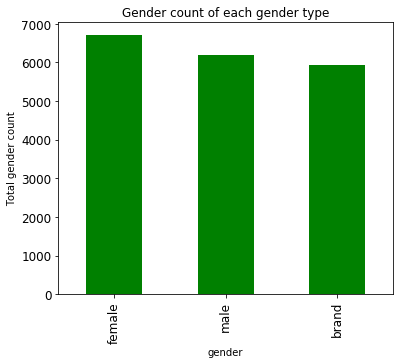

In [8]:
sub_df['gender'].value_counts().plot(kind='bar', color='green', figsize = (6,5), fontsize = 12)
plt.xlabel('gender')
plt.ylabel('Total gender count')
plt.title('Gender count of each gender type')

Now, I try to check how many tweet counts each gender has, so that we get a fair idea of which gender has more tweet counts.

In [9]:
female_tweets = sub_df["gender"] == "female"
male_tweets = sub_df["gender"] == "male"
brand_tweets = sub_df["gender"] == "brand"

In [10]:
female_rows = sub_df[female_tweets]
male_rows = sub_df[male_tweets]
brand_rows = sub_df[brand_tweets]

In [11]:
print("Total female tweets: ",female_rows.description.count())
print("Total male tweets:   ",male_rows.description.count())
print("Total brand tweets:  ",brand_rows.description.count())

Total female tweets:  5725
Total male tweets:    5469
Total brand tweets:   4328


We can try to label the gender so that it becomes easy later for us to detect which category is which gender, and also is helpful for our models later on

In [12]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18933 entries, 0 to 20049
Data columns (total 17 columns):
_golden                  18933 non-null bool
_unit_state              18933 non-null object
_trusted_judgments       18933 non-null int64
gender                   18836 non-null object
gender:confidence        18907 non-null float64
profile_yn               18933 non-null object
profile_yn:confidence    18933 non-null float64
description              15604 non-null object
fav_number               18933 non-null int64
gender_gold              50 non-null object
link_color               18933 non-null object
name                     18933 non-null object
profile_yn_gold          50 non-null object
retweet_count            18933 non-null int64
sidebar_color            18933 non-null object
text                     18933 non-null object
tweet_count              18933 non-null int64
dtypes: bool(1), float64(2), int64(4), object(10)
memory usage: 2.5+ MB


In [13]:
sub_df.isna().sum()

_golden                      0
_unit_state                  0
_trusted_judgments           0
gender                      97
gender:confidence           26
profile_yn                   0
profile_yn:confidence        0
description               3329
fav_number                   0
gender_gold              18883
link_color                   0
name                         0
profile_yn_gold          18883
retweet_count                0
sidebar_color                0
text                         0
tweet_count                  0
dtype: int64

We see here that the description content has NaN values/missing. I think it would be fine to drop those missing values since it's a description content, and we would not be able to replace those values. So I will go ahead and perform the clean up.

#### b. Profile feature(profile_yn, profile_yn_gold)

**No':** Profile was meant to be part of the dataset but was not available when contributors went to judge it.

Since, we have 97 instances from the DataFrame which has the option **No**, we can remove all these.

In [14]:
profile_yn_idx = sub_df[sub_df['profile_yn'] == 'no'].index
sub_df.drop (index = profile_yn_idx, inplace = True)
print(sub_df['profile_yn'].value_counts())

yes    18836
Name: profile_yn, dtype: int64


I think we can remove the profile_yn:confidence and profile_yn_gold as this may contain little to no information to us.

In [15]:
sub_df.drop(columns=['profile_yn_gold'], inplace=True)
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18836 entries, 0 to 20049
Data columns (total 16 columns):
_golden                  18836 non-null bool
_unit_state              18836 non-null object
_trusted_judgments       18836 non-null int64
gender                   18836 non-null object
gender:confidence        18836 non-null float64
profile_yn               18836 non-null object
profile_yn:confidence    18836 non-null float64
description              15522 non-null object
fav_number               18836 non-null int64
gender_gold              50 non-null object
link_color               18836 non-null object
name                     18836 non-null object
retweet_count            18836 non-null int64
sidebar_color            18836 non-null object
text                     18836 non-null object
tweet_count              18836 non-null int64
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [16]:
sub_df['_unit_state'].value_counts()

finalized    18786
golden          50
Name: _unit_state, dtype: int64

#### c. Low Confidence gender(gender:confidence)

In [17]:
sub_df['gender:confidence'].value_counts()

1.0000    13804
0.6691       29
0.6667       27
0.6619       27
0.6743       26
          ...  
0.3582        1
0.5540        1
0.3330        1
0.3458        1
0.3534        1
Name: gender:confidence, Length: 892, dtype: int64

In [18]:
print ('Full data items: ', sub_df.shape)
print ('Data with label-confidence < 100%: ', sub_df[sub_df['gender:confidence'] < 1].shape)

Full data items:  (18836, 16)
Data with label-confidence < 100%:  (5032, 16)


We see here that there is almost 1/5th of the data which has low confidence of less than 100%. So we can remove those which are not fully 100%

In [19]:
gender_confidence_idx = sub_df[sub_df['gender:confidence'] < 1].index
sub_df.drop (index = gender_confidence_idx, inplace = True)
print (sub_df['gender:confidence'].value_counts())

1.0    13804
Name: gender:confidence, dtype: int64


I will remove the unnecessary columns which I think would not be useful for detecting the gender using tweets.

In [20]:
sub_df.drop(columns = ['_golden','_unit_state','_trusted_judgments','gender_gold'], inplace = True)
print(sub_df['gender'].value_counts())
sub_df.info()

female    5367
male      4653
brand     3784
Name: gender, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13804 entries, 0 to 20049
Data columns (total 12 columns):
gender                   13804 non-null object
gender:confidence        13804 non-null float64
profile_yn               13804 non-null object
profile_yn:confidence    13804 non-null float64
description              11773 non-null object
fav_number               13804 non-null int64
link_color               13804 non-null object
name                     13804 non-null object
retweet_count            13804 non-null int64
sidebar_color            13804 non-null object
text                     13804 non-null object
tweet_count              13804 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 1.4+ MB


In [21]:
sub_df[['description', 'text']]

,description,text
0,i sing my own rhythm.,Robbie E Responds To Critics After Win Against...
1,I'm the author of novels filled with family dr...,ÛÏIt felt like they were my friends and I was...
3,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Hi @JordanSpieth - Looking at the url - do you...
4,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Watching Neighbours on Sky+ catching up with t...
5,you don't know me.,"Ive seen people on the train with lamps, chair..."
...,...,...
20044,I Love Me...Myself....&....I,Need A Ride Home From Practice _Ù÷Ô_Ù÷Ô_Ù÷ÔAnd...
20045,(rp),"@lookupondeath ...Fine, and I'll drink tea too..."
20046,"Whatever you like, it's not a problem at all. ...",Greg Hardy you a good player and all but don't...
20047,#TeamBarcelona ..You look lost so you should f...,You can miss people and still never want to se...


### 2.1 Manipulating text data

We now need to somehow manipulate the text data for our data to preprocess and be useful for our models later. NLP contains a library called NLTK. It stands for Natural Language Toolkit. This toolkit is one of the most powerful NLP libraries which contains packages to make machines understand human language and reply to it with an appropriate response. Tokenization, Stemming, Lemmatization, Punctuation, Character count, word count are some of these packages present. We will now try to apply some of the methods for our text to be useful.

First, we will download the nltk stopwords and some other modules required.

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ravi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ravi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ravi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We can first check the most common words in both the description and the text columns

In [25]:
from collections import Counter

twit_word = Counter()
for twit in sub_df['text']:
    for word in twit.split(' '):
        twit_word[word] += 1

most_common_words= twit_word.most_common(20)
most_common_words

[('the', 8370),
 ('and', 7964),
 ('to', 4196),
 ('I', 3229),
 ('a', 3064),
 ('of', 2741),
 ('in', 2270),
 ('you', 2173),
 ('for', 2157),
 ('The', 2018),
 ('is', 1878),
 ('on', 1621),
 ('my', 1362),
 ('it', 1205),
 ('', 1184),
 ('with', 1156),
 ('Weather', 1074),
 ('that', 1032),
 ('from', 1022),
 ('me', 1001)]

In [26]:
most_common_words_df = pd.DataFrame(most_common_words, columns = ['common_words', 'count']).sort_values(by=['count'], ascending=True)
most_common_words_df

,common_words,count
19,me,1001
18,from,1022
17,that,1032
16,Weather,1074
15,with,1156
14,,1184
13,it,1205
12,my,1362
11,on,1621
10,is,1878


Text(0.5, 0, 'count')

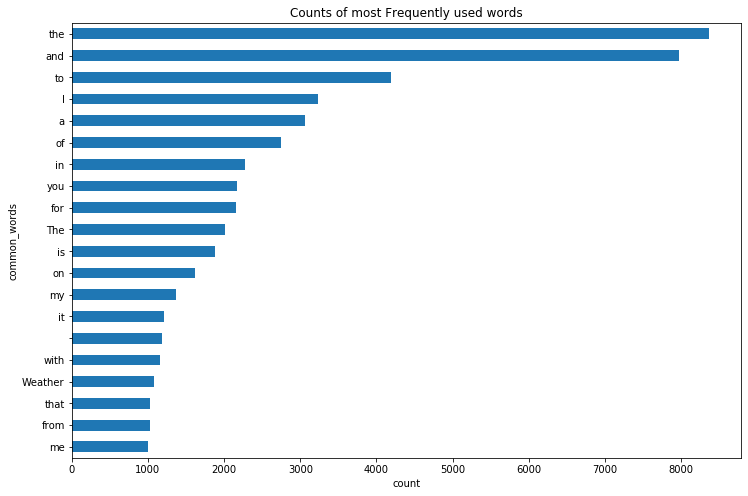

In [27]:
most_common_words_df.plot(x='common_words', y='count', kind='barh', figsize = (12,8), legend=False, title= 'Counts of most Frequently used words')
plt.xlabel('count')

In [28]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13804 entries, 0 to 20049
Data columns (total 12 columns):
gender                   13804 non-null object
gender:confidence        13804 non-null float64
profile_yn               13804 non-null object
profile_yn:confidence    13804 non-null float64
description              11773 non-null object
fav_number               13804 non-null int64
link_color               13804 non-null object
name                     13804 non-null object
retweet_count            13804 non-null int64
sidebar_color            13804 non-null object
text                     13804 non-null object
tweet_count              13804 non-null int64
dtypes: float64(2), int64(3), object(7)
memory usage: 1.4+ MB


In [29]:
#Fill NaN with empty string
sub_df.fillna("", inplace = True)

# Concatenate text with description, add white space between. 
# By using Series helper functions Series.str()
sub_df['Tweets'] = sub_df['text'].str.cat(sub_df['description'], sep=' ')

sub_df['Tweets'].isnull().value_counts() # Check if any null values, True if there is at least one.

False    13804
Name: Tweets, dtype: int64

In [30]:
sub_df['Tweets'][:3]

0    Robbie E Responds To Critics After Win Against...
1    ÛÏIt felt like they were my friends and I was...
3    Hi @JordanSpieth - Looking at the url - do you...
Name: Tweets, dtype: object

#### a. Removing Stopwords and applying Lemmatization

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore. In natural language processing, useless words (data), are referred to as stop words. 

Lemmatization is also stemming but produces results which are all valid words.

Also, a regular expression is used below to specify a set of strings that matches it; tthey allow to check if a particular string matches a given regular expression. Now let us perform these operations

In [31]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemma= WordNetLemmatizer() 

def cleaning(s):
    # regex to clean unnecesarry chars
    s = re.sub("[^a-zA-Z]"," ", str(s))
    s = re.sub('\s\W',' ',str(s))
    s = re.sub('\W,\s',' ',str(s))
    s = re.sub(r'[^\w]', ' ', str(s))
    s = re.sub("\d+", "", str(s))
    s = re.sub('\s+',' ',str(s))
    s = re.sub('[!@#$_]', '', str(s))
    s = s.replace("co","")
    s = s.replace("http","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    s = s.lower()  # convert all to lowercase                                                             
    s = nltk.word_tokenize(s)  # split all by tokenizing the words into tokens                                                 
    s = [word for word in s if not word in set(stopwords.words("english"))]    # delete stop words from the array
    s = [lemma.lemmatize(word) for word in s]      # lemmatize "memories" -> "memory"
    s = " ".join(s) # make them one string again
    return s

sub_df['Tweets'] = [cleaning(s) for s in sub_df['Tweets']]

In [32]:
sub_df['Tweets']

0        robbie e responds critic win eddie edward worl...
1        felt like friend living story arnge yhno retir...
3        hi jordanspieth looking url use ifttt typicall...
4        watching neighbour sky catching neighbs xxx xx...
5        ive seen people train lamp chair tv etc w zf p...
                               ...                        
20044        need ride home practice raining hard asf love
20045                 lookupondeath fine drink tea love rp
20046    greg hardy good player get face dez bryant lea...
20047    miss people still never want see teambarcelona...
20049    think apush creative project going bring ban c...
Name: Tweets, Length: 13804, dtype: object

In [33]:
# Counter: Useful in counting the most common words in a text. This is counting from 'Tweets' column
tweet_list = Counter()
for tweet in sub_df['Tweets']:
    for words in tweet.split(' '):
        tweet_list[words] += 1

common_words= tweet_list.most_common(20)
common_words

[('get', 1516),
 ('love', 1310),
 ('weather', 1128),
 ('like', 1077),
 ('u', 1019),
 ('one', 901),
 ('life', 872),
 ('time', 821),
 ('day', 741),
 ('news', 740),
 ('new', 734),
 ('update', 715),
 ('make', 692),
 ('channel', 621),
 ('best', 617),
 ('go', 604),
 ('people', 597),
 ('world', 585),
 ('know', 550),
 ('music', 547)]

In [34]:
# Removing duplicate words in a sentence/string if any. Code is taken from  https://stackoverflow.com/questions/47316783/python-dataframe-remove-duplicate-words-in-the-same-cell-within-a-column-in-pyt
from collections import OrderedDict

sub_df['Tweets_cleaned'] = (sub_df['Tweets'].str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

In [35]:
# Counter: Useful in counting the most common words in a text. This is counting from 'Tweets_cleaned' column.
tweet_list = Counter()
for tweet in sub_df['Tweets_cleaned']:
    for words in tweet.split(' '):
        tweet_list[words] += 1

common_words= tweet_list.most_common(20)
common_words

[('get', 1453),
 ('love', 1128),
 ('like', 985),
 ('u', 895),
 ('one', 844),
 ('life', 815),
 ('time', 758),
 ('new', 699),
 ('day', 687),
 ('make', 662),
 ('news', 650),
 ('update', 643),
 ('channel', 620),
 ('best', 581),
 ('weather', 576),
 ('go', 572),
 ('world', 560),
 ('people', 549),
 ('know', 515),
 ('thing', 507)]

In [36]:
sub_df['Tweets_cleaned']

0        robbie e responds critic win eddie edward worl...
1        felt like friend living story arnge yhno retir...
3        hi jordanspieth looking url use ifttt typicall...
4        watching neighbour sky catching neighbs xxx ri...
5        ive seen people train lamp chair tv etc w zf p...
                               ...                        
20044        need ride home practice raining hard asf love
20045                 lookupondeath fine drink tea love rp
20046    greg hardy good player get face dez bryant lea...
20047    miss people still never want see teambarcelona...
20049    think apush creative project going bring ban c...
Name: Tweets_cleaned, Length: 13804, dtype: object

In [37]:
common_words_df = pd.DataFrame(common_words, columns = ['common_words', 'count']).sort_values(by=['count'], ascending=True)
common_words_df

,common_words,count
19,thing,507
18,know,515
17,people,549
16,world,560
15,go,572
14,weather,576
13,best,581
12,channel,620
11,update,643
10,news,650


Text(0.5, 0, 'count')

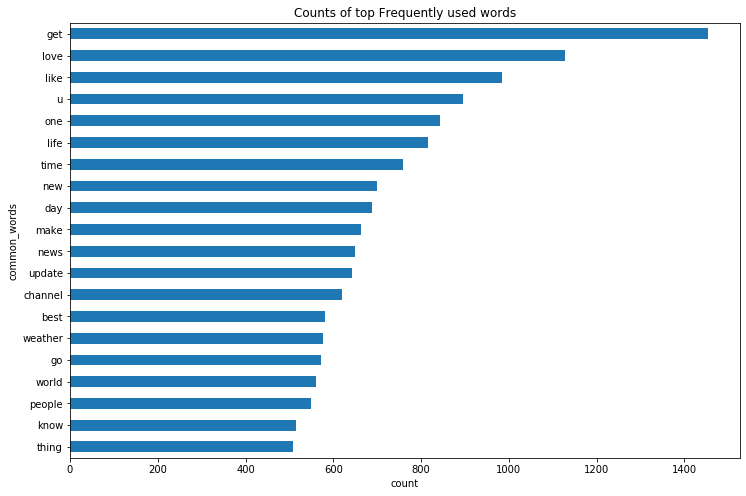

In [38]:
common_words_df.plot(x='common_words', y='count', kind='barh', figsize = (12,8), legend=False, title= 'Counts of top Frequently used words')
plt.xlabel('count')

#### b. Generating a WordCloud

Ususally, whenever we deal with NLP or text, we see a cloud filled with lots of words in different sizes, which represent the frequency or the importance of each word. Wordcloud is the exact representation of this. It is a data Visualization technique used for text analysis. Let us now try it on our dataset.

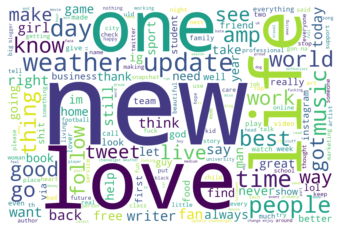

In [39]:
# Generating a word cloud of frequency of text
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=1500, height=1000).generate(''.join(sub_df['Tweets_cleaned']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From the image, we now see that the words new, love, life, one etc.. are displayed in a large font, meaning that these words occur very frequently and the frequency for these words is more.

#### c. Gender Tweets

Let us now try to look at the gender tweet counts on how many male tweet word counts are present and how many female word tweets. This is for visualization purpose.

In [40]:
sub_df['gender']

0          male
1          male
3          male
4        female
5        female
          ...  
20044    female
20045    female
20046      male
20047      male
20049    female
Name: gender, Length: 13804, dtype: object

In [41]:
sub_df.gender.value_counts()
male = sub_df[sub_df['gender'] == 'male']
female = sub_df[sub_df['gender'] == 'female']
male_words = pd.Series(' '.join(male['Tweets_cleaned'].astype(str)).lower().split(" ")).value_counts()[:20]
female_words = pd.Series(' '.join(female['Tweets_cleaned'].astype(str)).lower().split(" ")).value_counts()[:20]
male_words = male_words.iloc[1:]
female_words = female_words.iloc[1:]

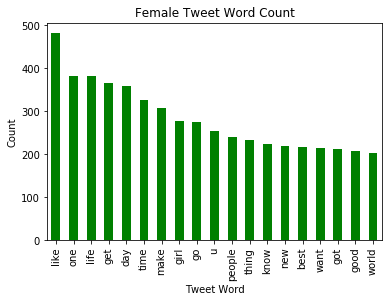

In [42]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title("Female Tweet Word Count")
plt.xlabel("Tweet Word")
plt.ylabel("Count")
female_words.plot(kind='bar', color="green")

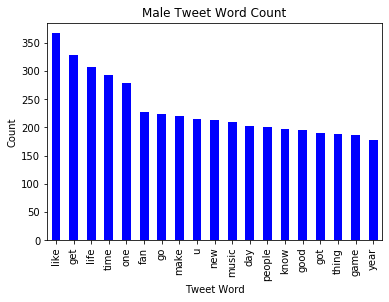

In [43]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.title("Male Tweet Word Count")
plt.xlabel("Tweet Word")
plt.ylabel("Count")
male_words.plot(kind='bar', color="blue")